# Analysis of climate data

In this tutorial we present some examples how to:
- create and regrid data
- create climate indices
- extract and analyse time series
- get spatial correlation analysis

In [31]:
# load libraries and files
import xarray as xr
import geoutils.utils.file_utils as fut
import geoutils.utils.general_utils as gut
import geoutils.utils.statistic_utils as sut
import geoutils.utils.spatial_utils as sput
import geoutils.utils.time_utils as tu
import geoutils.tsa.time_series_analysis as tsa
import geoutils.geodata.base_dataset as bds
import geoutils.indices.enso_utils as eut
import geoutils.plotting.plots as cplt
from importlib import reload

output_dir = "/home/strnad/data/"
data_dir = "/home/strnad/data/"
plot_dir = "/home/strnad/data/plots/tutorial/"
output_folder = "tutorial"



In [3]:
# Load the data files
# SSTs
reload(bds)
dataset_file = data_dir + \
    f"/climate_data/2.5/era5_sst_{2.5}_ds.nc"

ds_sst = bds.BaseDataset(data_nc=dataset_file,
                         can=True,
                         an_types=['JJAS', 'month', 'dayofyear'],  # compute the anomalies wrt JJAS, month and dayofyear
                         )

File location: /home/strnad/data/climate_data/2.5/era5_sst_2.5_ds.nc
File size: 629.94 MB
Start processing data!
3d object transposed to lat-lon-time!
Sorted longitudes and latitudes in ascending order!
Set time to np.datetime[ns] time format!
set hours to 0
Different grid step in lon 2.52 and lat 2.5 direction!
Finished processing data
Set variable name to sst!
Created JJASly anomalies!
Rename sst to sst_an_JJAS!
Created monthly anomalies!
Rename sst to sst_an_month!
Created dayofyearly anomalies!
Rename sst to sst_an_dayofyear!
WARNING! No mask initialized!
Set dataset source attributes!


In [7]:
# compute the ENSO index
reload(eut)
reload(cplt)
nino_indices = eut.get_nino_indices(ssta=ds_sst.ds['an_month'])
n34 = nino_indices['nino34']

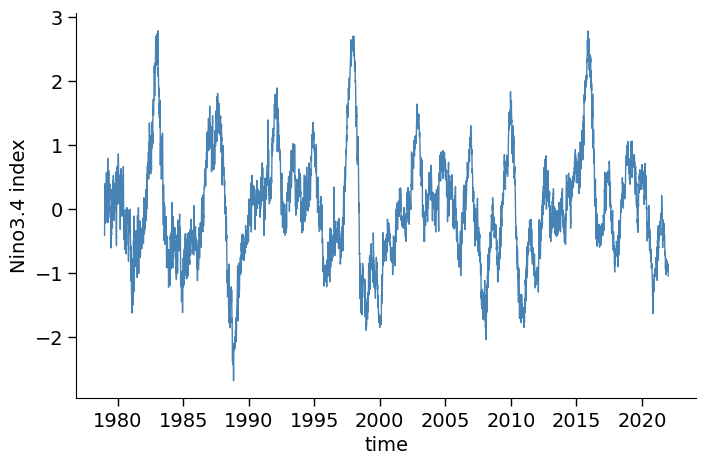

In [9]:
# plot the Nino3.4 index
im = cplt.plot_xy(x_arr=[n34.time],
             y_arr=[n34],
             xlabel='time',
             ylabel='Nino3.4 index',)

## Composite analysis

It is often useful to plot the average of specific time points, because these might show some common pattern. 

Here we use the well known definition of El Nino state (La Nina state) by selecting all time points for which Nino3.4 > 0.5 (Nino3.4 < 0.5)

Dateline set to true!


Dateline set to true!
Dateline set to true!


/home/strnad/climnet/geoutils/geoutils/plotting/map_plots.py:1070: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Dateline set to true!


/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Dateline set to true!


/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Dateline set to true!


/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


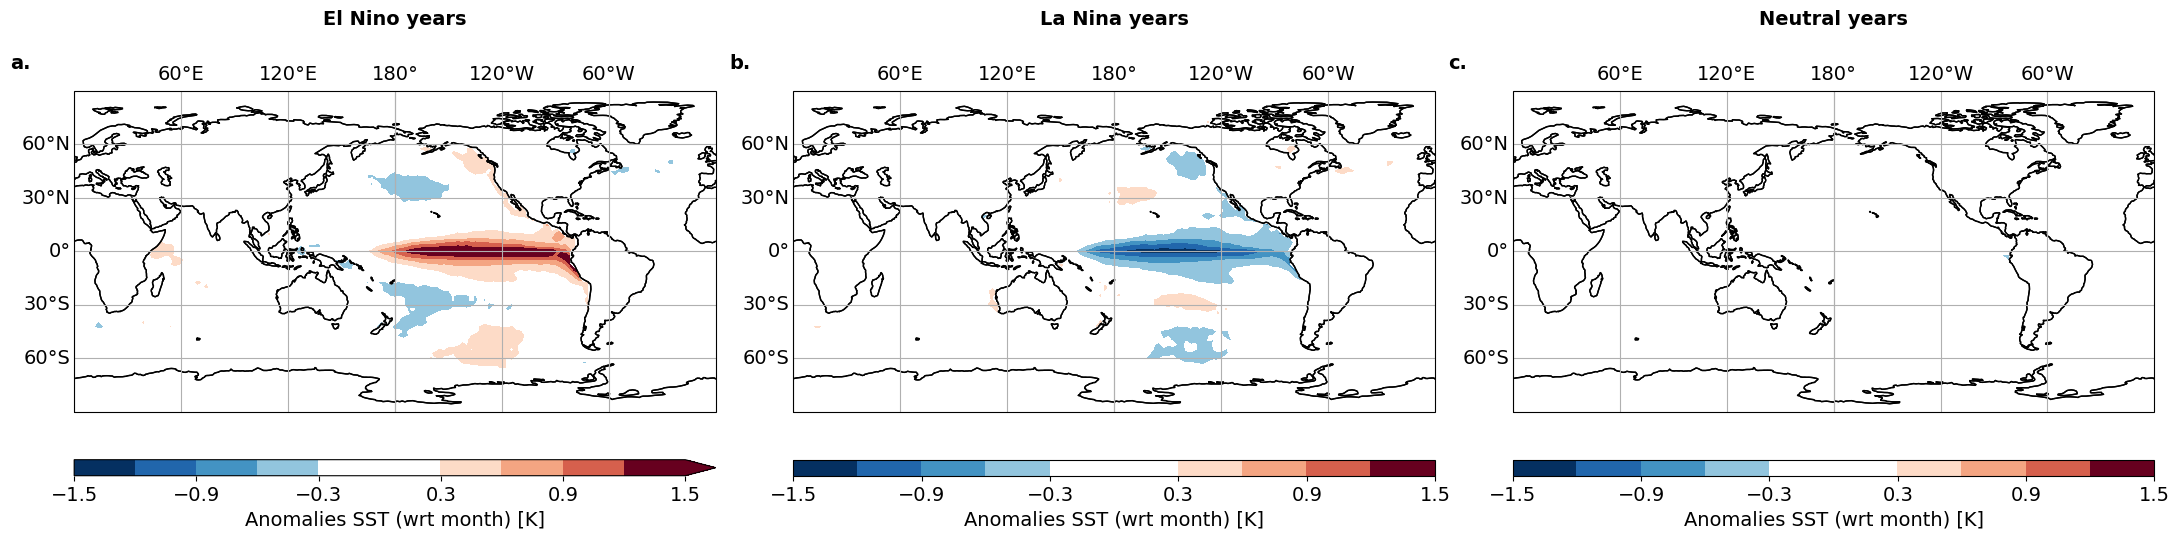

In [50]:
# get specific time points
reload(cplt)
nino_tps = n34[n34 >= 0.5]
nina_tps = n34[n34 <= -0.5]
neutral_tps = n34[(n34 < 0.5) & (n34 > -0.5)]

# plot specific time points as composite maps
an_type = 'month'
var_type = f'an_{an_type}'
label = f'Anomalies SST (wrt {an_type}) [K]'
vmax = 1.5
vmin = -vmax
yt = [
    'El Nino years',
    'La Nina years',
    'Neutral years']

im = cplt.create_multi_plot(nrows=1, ncols=3, 
                            # figsize=(12, 5),
                            projection='PlateCarree', 
                            dateline=180,
                            hspace=0.1, 
                            wspace=0.1)
for i, tps in enumerate([nino_tps, nina_tps, neutral_tps]):
    # select the specific time points
    data = tu.get_sel_tps_ds(ds=ds_sst.ds[var_type], tps=tps)
    
    # create composites and also determine if these are statistically significant
    mean, pvalues_ttest = sut.ttest_field(
        data, ds_sst.ds[var_type])
    mask = sut.field_significance_mask(
        pvalues_ttest, alpha=0.001)

    # plot the composites
    im_comp = cplt.plot_map(mean,
                            ax=im['ax'][i],
                            title=f'{yt[i]}',
                            plot_type='contourf',
                            cmap='RdBu_r',
                            centercolor='white',
                            levels=10,
                            label=label,
                            # significance_mask=mask,
                            vmin=vmin, vmax=vmax,
                            tick_step=2,
                            )


## Correlation analysis
To analyze the spatial effect of an index, it is sometimes also useful to plot its correlation to all spatial timeseries of a dataset.

Here we plot the Spearman's correlation of the Nino3.4 index to the global SST field.

In [30]:
# Create spatial correlation plot
reload(sput)
lag = 0
corr = sput.compute_correlation(
data_array=ds_sst.ds[var_type],
ts=n34,
lag_arr=[lag],
multi_lag=False,
correlation_type='spearman')


Computing spearman correlation for 144 locations ...


100%|██████████| 144/144 [00:24<00:00,  5.76it/s]


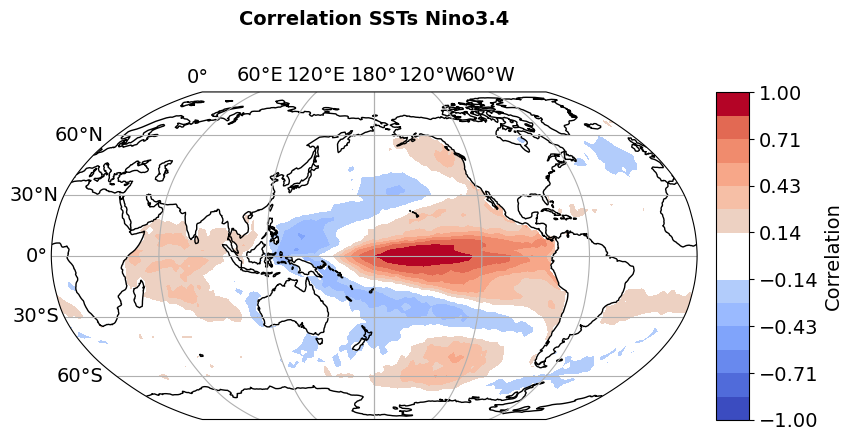

In [28]:
vmax = 1
vmin = -vmax
im = cplt.plot_map(
            corr['corr'].sel(lag=lag),
            # significance_mask=corr['p'].sel(lag=lag) < 0.0001,
            sig_plot_type='contour',
            projection='Robinson',
            cmap='coolwarm',
            levels=14,
            plot_type='contourf',
            label=f'Correlation',
            title=f'Correlation SSTs Nino3.4',
            vmin=vmin,
            vmax=vmax,
            orientation='vertical',
            round_dec=2,
            centercolor='white',
            dateline=True
        )


## Analyze extremes
Here we select the extreme time points, called the super El Ninos by selecting time points that are in the top 5% of the Nino3.4 index

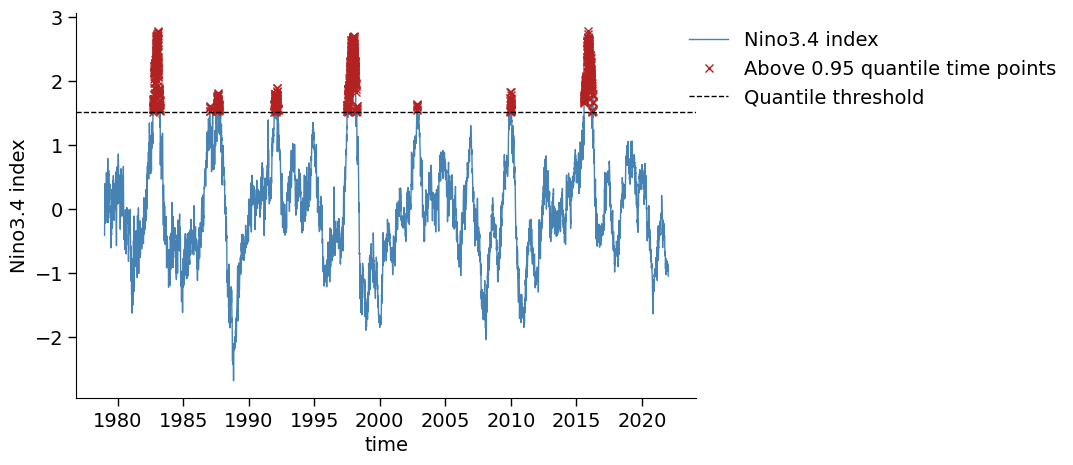

In [58]:
reload(cplt)
q_th = 0.95  # quantile threshold
q_val = n34.quantile(q=q_th)
q_tps = gut.get_quantile_of_ts(ts=n34,
                               q=q_th)


im = cplt.plot_xy(x_arr=[n34.time, q_tps.time],
             y_arr=[n34, q_tps],
             xlabel='time',
             ylabel='Nino3.4 index',
             ls_arr=['-', ''],
             mk_arr=['', 'x'],
             label_arr=['Nino3.4 index', 
                        f'Above {q_th} quantile time points'],
             set_legend=False)
cplt.plot_hline(ax=im['ax'],
                y=q_val,
                label=f'Quantile threshold')
_ = cplt.set_legend(ax=im['ax'],
                loc='outside')

/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/strnad/anaconda3/envs/climnet/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


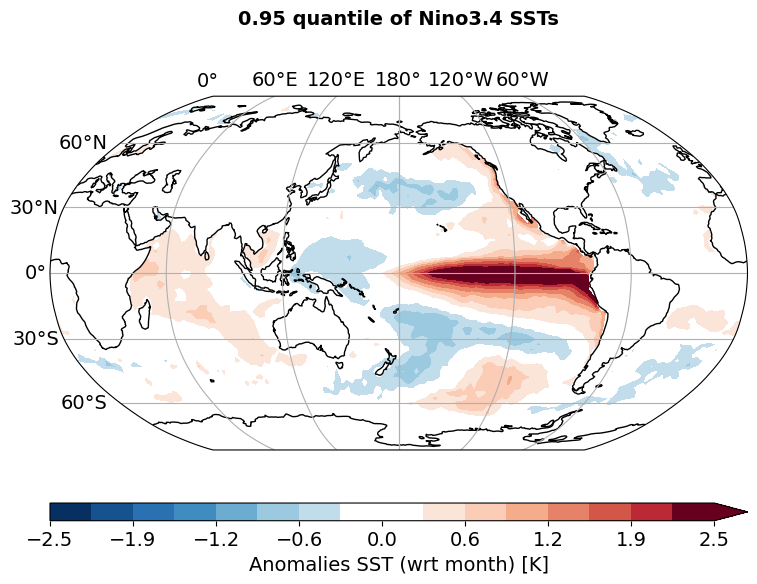

In [57]:
# Plot the extreme composites for the SSTs
data = tu.get_sel_tps_ds(ds=ds_sst.ds[var_type], tps=q_tps)
    
# create composites and also determine if these are statistically significant
mean, pvalues_ttest = sut.ttest_field(
    data, ds_sst.ds[var_type])
mask = sut.field_significance_mask(
    pvalues_ttest, alpha=0.001)

label = f'Anomalies SST (wrt {an_type}) [K]'
vmax = 2.5
vmin = -vmax

# plot the composites
im_comp = cplt.plot_map(mean,
                        title=f'{q_th} quantile of Nino3.4 SSTs',
                        plot_type='contourf',
                        cmap='RdBu_r',
                        centercolor='white',
                        levels=16,
                        label=label,
                        vmin=vmin, vmax=vmax,
                        tick_step=2,
                        dateline=True,
                        projection='Robinson'
                        )